<a href="https://colab.research.google.com/github/Festivius/ReGen/blob/main/find_the_yum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tensorflow import keras
from keras import layers
from keras.applications import VGG16

import numpy as np
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

from PIL import Image
import torch
from torchvision import transforms


plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

tf.config.run_functions_eagerly(True)

FRUIT DATA CREATING CSV


In [25]:
images_train = []
labels_train = []

for i in range(len(train_filenames)):
    try:
      img_name = train_filenames[i]
      label = train_categories[i]

      image = Image.open(img_name).convert('RGB')
      image = image.resize((224,224))
      image_array = np.array(image)

      images_train.append(image_array)
      labels_train.append(label)
    except:
      pass

np_images_train = np.array(images_train)
np_labels_train = np.array(labels_train)


In [26]:
from sklearn.utils import shuffle

np_images_train = np_images_train.reshape(np_images_train.shape[0], -1)
X_train = pd.DataFrame(np_images_train)

np_labels_train = np_labels_train.reshape(np_labels_train.shape[0], -1)
y_train = pd.DataFrame(np_labels_train)

X_train, y_train = shuffle(X_train, y_train, random_state=42)


'''np_images_test = np_images_test.reshape(np_images_test.shape[0], -1)
X_test = pd.DataFrame(np_images_test)

np_labels_test = np_labels_test.reshape(np_labels_test.shape[0], -1)
y_test = pd.DataFrame(np_labels_test)

X_test, y_test = shuffle(X, y, random_state=42)'''

'np_images_test = np_images_test.reshape(np_images_test.shape[0], -1)\nX_test = pd.DataFrame(np_images_test)\n\nnp_labels_test = np_labels_test.reshape(np_labels_test.shape[0], -1)\ny_test = pd.DataFrame(np_labels_test)\n\nX_test, y_test = shuffle(X, y, random_state=42)'

In [28]:
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train.values.ravel())  # Ensure y is 1D
'''y_encoded_test = label_encoder.fit_transform(y_test.values.ravel())  # Ensure y is 1D'''

'y_encoded_test = label_encoder.fit_transform(y_test.values.ravel())  # Ensure y is 1D'

In [30]:
batch_size = X_train.shape[0]  # Number of samples
height = 224  # Original height of images
width = 224   # Original width of images
channels = 3  # Number of channels (e.g., 3 for RGB)

# Reshape the flattened images back to 3D shape
X_reshaped_train = X_train.values.reshape(batch_size, height, width, channels)

# Now you can resize the images
X_resized_train = tf.image.resize(X_reshaped_train, (224, 224))
X_resized_train = X_resized_train.numpy().astype('float32')  # Ensure dtype is float32
# Normalize pixel values to [0, 1]
X_resized_train = X_resized_train / 255.0

# Now X_resized is ready for training or prediction
print(X_resized_train.shape)  # Should print (batch_size, 224, 224, 3)

X_train = X_resized_train

'''
batch_size = X_test.shape[0]  # Number of samples

X_resized_test = X_test.values.reshape(batch_size, height, width, channels)
X_resized_test = tf.image.resize(X_resized_test, (224, 224))
X_resized_test = X_resized_test.numpy().astype('float32')
X_resized_test = X_resized_test / 255.0

X_test = X_resized_test'''

(2301, 224, 224, 3)


"\nbatch_size = X_test.shape[0]  # Number of samples\n\nX_resized_test = X_test.values.reshape(batch_size, height, width, channels)\nX_resized_test = tf.image.resize(X_resized_test, (224, 224))\nX_resized_test = X_resized_test.numpy().astype('float32')\nX_resized_test = X_resized_test / 255.0\n\nX_test = X_resized_test"

In [29]:
"""import os

train_path = "/content/drive/My Drive/regen_fruit_dataset/train"
test_path = "/content/drive/My Drive/regen_fruit_dataset/test"
fruit_categories = {
    'Apple': 0,
    'Banana': 1,
    'avocado': 2,
    'cherry': 3,
    'kiwi': 4,
    'mango': 5,
    'orange': 6,
    'pinenapple': 7,
    'strawberries': 8,
    'watermelon': 9
}

train_filenames = []
train_categories = []
for fruit in fruit_categories.keys():
    fruit_path = os.path.join(train_path, fruit)
    for fruit_image in os.listdir(fruit_path):
        fullpath = os.path.join(fruit_path, fruit_image)
        train_filenames.append(fullpath)
        train_categories.append(fruit_categories[fruit])

print(train_filenames)
df_train = pd.DataFrame({'filename':train_filenames, 'category': train_categories})

X_resized_train = tf.image.resize(X_train, (224, 224))  # Resize to (224, 224)
X_resized_train = X_resized_train.numpy().astype('float32')  # Ensure dtype is float32
X_resized_train /= 255.0  # Normalize pixel values to [0, 1]

X_train = X_resized_train"""

['/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_2301.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_1521.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_5801.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_5791.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_2071.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_3241.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_941.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_5241.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_2871.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_1131.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_441.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_91.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/Apple/img_5271.jpeg', '/content/drive/My Drive/regen_fruit_dataset/train/App

ValueError: 'images' must have either 3 or 4 dimensions.

In [39]:
X_train

array([[[[0.79607844, 0.80784315, 0.8352941 ],
         [0.79607844, 0.80784315, 0.8352941 ],
         [0.8039216 , 0.8156863 , 0.84313726],
         ...,
         [0.7647059 , 0.7764706 , 0.8039216 ],
         [0.7607843 , 0.77254903, 0.80784315],
         [0.7607843 , 0.77254903, 0.80784315]],

        [[0.79607844, 0.80784315, 0.8352941 ],
         [0.79607844, 0.80784315, 0.8352941 ],
         [0.8039216 , 0.8156863 , 0.84313726],
         ...,
         [0.7647059 , 0.7764706 , 0.8039216 ],
         [0.7607843 , 0.77254903, 0.80784315],
         [0.7607843 , 0.77254903, 0.80784315]],

        [[0.79607844, 0.80784315, 0.8352941 ],
         [0.8       , 0.8117647 , 0.8392157 ],
         [0.80784315, 0.81960785, 0.84705883],
         ...,
         [0.7647059 , 0.7764706 , 0.8039216 ],
         [0.7607843 , 0.77254903, 0.80784315],
         [0.7607843 , 0.77254903, 0.80784315]],

        ...,

        [[0.88235295, 0.89411765, 0.92156863],
         [0.88235295, 0.89411765, 0.92156863]

In [45]:
base_model = VGG16(weights='imagenet')
base_model.trainable = False

model = keras.Sequential([
    #base_model,
    layers.Flatten(),
    layers.BatchNormalization(input_shape=(X_train.shape[1],)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(len(label_encoder.classes_), activation='softmax'),  # Matches # classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
)

In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='sparse_categorical_crossentropy',  # Integer labels
    metrics=['accuracy'],
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/256


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1154 - loss: 3.0916

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.1160 - loss: 3.0842 - val_accuracy: 0.1215 - val_loss: 2.9434
Epoch 2/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.2321 - loss: 2.5442 - val_accuracy: 0.1258 - val_loss: 2.5819
Epoch 3/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.2564 - loss: 2.3131 - val_accuracy: 0.1649 - val_loss: 2.3477
Epoch 4/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.2952 - loss: 2.2212 - val_accuracy: 0.1931 - val_loss: 2.2205
Epoch 5/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.3127 - loss: 2.1400 - val_accuracy: 0.2017 - val_loss: 2.1587
Epoch 6/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3229 - loss: 2.0395 - val_accuracy: 0.2104 - val_loss: 2.0828
Epoch 7/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 600ms/step - accuracy: 0.3680 - loss: 1.9201 - val_accuracy: 0.2451 - val_loss: 2.0406
Epoch 8/256
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.3850 - loss: 1.7889 - val_accuracy: 0.2842

<Axes: title={'center': 'Accuracy'}>

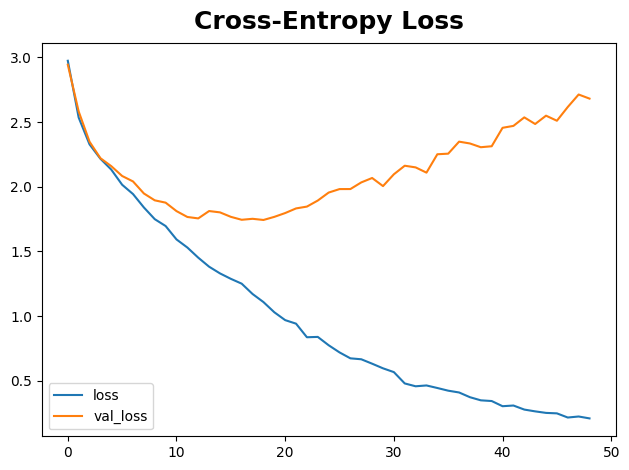

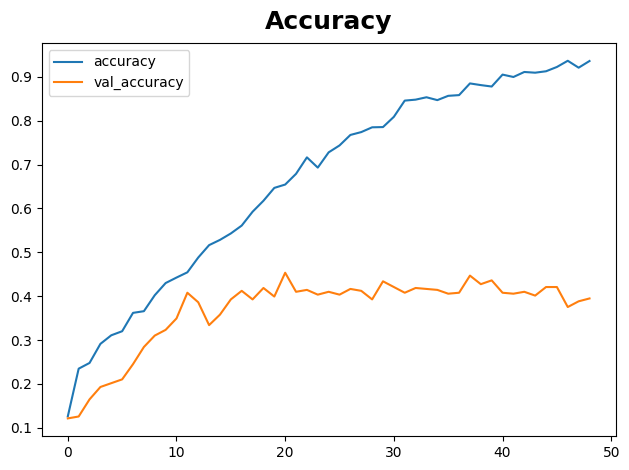

In [48]:
history = model.fit(
    X_train, y_train,
    #validation_data=(), ########################################## CHANGE HERE
    batch_size=128,  # Smaller batch size
    epochs=256,
    validation_split=0.2,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-Entropy Loss")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [38]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image and preprocess
img_path = "/content/drive/My Drive/regen_fruit_dataset/train/Banana/img_1371.jpeg"

# Load the image (resize it to 128x128 as expected by the model)
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add the batch dimension
img_array = np.expand_dims(img_array, axis=0)  # This will change the shape to (1, 128, 128, 3)

# Normalize the image if needed (based on how you processed it during training)
img_array = img_array / 255.0  # If you scaled during training

# Now you can use this img_array to make predictions
predictions = model.predict(img_array)

# If you're doing classification, find the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# If you have the list of labels for classes
fruit_categories = [
    'Apple',
    'Banana',
    'avocado',
    'cherry',
    'kiwi',
    'mango',
    'orange',
    'pinenapple',
    'strawberries',
    'watermelon']
predicted_label = fruit_categories[predicted_class[0]]

print(f"Predicted class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: Banana


In [ ]:
model.save('ReGen_CNN.keras')